In [76]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.impute import KNNImputer


In [2]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Definir el problema
El proyecto del curso consiste en para predecir si una empresa entrará en bancarrota o no al año siguiente, utilizando una serie de métricas financieras como variables predictoras. 

## Datos
La descripción de las variables predictoras se presentan a continuación:


* Fracaso: 1 si la empresa entró en bancarrota al día siguiente, 0 de lo contrario (variable de respuesta)

* B11: ratio of Cash flow to sales

* B12: ratio of Cash flow to total assets

* B13: ratio of Cash flow to net worth

* B14: ratio of Cash Flow to total debt

* B21: ratio of Net income to sales

* B22: ratio of Net income to total assets

* B23: ratio of Net income to net worth

* B24: ratio of Net income to total debt

* B31: ratio of Current liabilities to total assets

* B32: ratio of Long-term liabilities to total assets

* B33: ratio of Current plus long-term liabilities to total assets

* B41: ratio of Cash to total assets

* B42: ratio of Quick assets to total assets

* B43: ratio of Current assets to total assets

* B44: ratio of Working capital to total assets

* B51: ratio of Cash to current liabilities

* B52: ratio of Quick assets to current liabilities

* B53: ratio of Current ratio

* B61: ratio of Cash to sales

* B62: ratio of Accounts receivable to sales

* B63: ratio of Inventory to sales

* B64: ratio of Quick assets to sales

* B65: ratio of Current assets to sales

* B66: ratio of Working capital to sales

* B67: ratio of Net worth to sales

* B68: ratio of Total assets to sales

* B69: Cash interval

* B610: Defensive Interval

* B611: No-credit interval

* A1: ratio of Working capital to total assets

* A2: ratio of Retained earnings to total assets

* A3: ratio of EBIT to total assets

* A4: ratio of Market value of equity to total liabilities

* A5: ratio of Sales to total assets

## Análisis exploratorio

In [54]:
train = pd.read_excel('/Users/natalia/Documents/Master_IA/competenciaML/fuente_datos/Train.xlsx', engine='openpyxl')
test = pd.read_excel('/Users/natalia/Documents/Master_IA/competenciaML/fuente_datos/Test.xlsx', engine='openpyxl')

def processdata(data):
    data['TAMA¥O'] = data['TAMA¥O'].replace('¥', 'Ñ', regex=True)
    data.rename(columns={'TAMA¥O':'TAMAÑO', 'TIPO.COMERCIO': 'TIPOCOMERCIO'}, inplace=True)
    return data

In [55]:
train = processdata(train)
test = processdata(test)

In [56]:
train.head()

,FRACASO,ACTIVOS,TAMAÑO,TIPOCOMERCIO,REGION,ZONA,B11,B12,B13,B14,...,B67,B68,B69,B610,B611,A1,A2,A3,A4,A5
0,1,678.749515,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,0.102777,0.052250,0.119351,0.092935,...,0.861137,1.967039,0.855297,4.060794,-1.952554,0.437086,0.267744,0.038029,0.778675,0.508378
1,0,4278.893204,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,-0.165065,-0.044984,-0.059135,-0.187988,...,2.791346,3.669408,0.714214,6.238498,4.835801,0.413594,0.005105,0.021488,3.178988,0.272524
2,0,773.634952,PEQUEÑA,POR MENOR,VALLE,OTRAS,0.091777,0.122194,0.586219,0.154371,...,0.156558,0.751082,0.325767,0.930060,-0.672028,0.213805,0.089447,0.066563,0.263334,1.331412
3,0,4846.850485,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,-0.229705,-0.081568,-0.525965,-0.096540,...,0.436730,2.816115,0.001792,3.698297,-2.690661,0.048942,0.145157,-0.113417,0.183548,0.355099
4,0,5932.570874,MEDIANA,POR MENOR,BOGOTA D.C.,CAPITAL,-0.005135,-0.025789,-0.141093,-0.031556,...,0.036396,0.199129,0.863850,1.743886,-0.746403,0.174258,0.000000,0.066147,0.223656,5.021868


In [57]:
test.head()

,ACTIVOS,TAMAÑO,TIPOCOMERCIO,REGION,ZONA,B11,B12,B13,B14,B21,...,B67,B68,B69,B610,B611,A1,A2,A3,A4,A5
0,1094.813592,PEQUEÑA,POR MAYOR,VALLE,OTRAS,-0.021526,-0.032418,-0.054478,-0.080060,0.019397,...,0.395125,0.663994,0.057835,3.837237,2.580051,0.624669,0.358935,0.065297,1.469583,1.506037
1,1368.706796,PEQUEÑA,POR MAYOR,BOGOTA D.C.,CAPITAL,0.013937,0.022078,0.085904,0.029715,0.054482,...,0.162235,0.631242,0.195862,3.385422,-0.784202,0.233104,0.333126,0.086309,0.345911,1.584179
2,4440.085437,PEQUEÑA,POR MENOR,SANTANDER,OTRAS,-0.006423,-0.021329,-0.077236,-0.029466,0.017213,...,0.083155,0.301119,0.074051,1.241192,-0.874639,0.086758,0.066302,0.090746,0.381509,3.320948
3,3112.401942,PEQUEÑA,POR MAYOR,CUNDINAMARCA,CAPITAL,-0.022739,-0.023294,-0.031462,-0.089729,0.029696,...,0.722744,0.976162,0.036933,1.302547,0.379837,0.225782,0.000000,0.051848,2.851979,1.024420
4,9423.293204,MEDIANA,POR MAYOR,ANTIOQUIA,OTRAS,0.056805,0.032271,0.050953,0.088015,0.013595,...,1.114860,1.760261,0.350952,1.503872,0.803586,0.667873,0.000000,0.014125,1.727393,0.568098


### Tipo de columna 

#### - Train

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FRACASO       2000 non-null   int64  
 1   ACTIVOS       2000 non-null   float64
 2   TAMAÑO        2000 non-null   object 
 3   TIPOCOMERCIO  2000 non-null   object 
 4   REGION        2000 non-null   object 
 5   ZONA          2000 non-null   object 
 6   B11           1981 non-null   float64
 7   B12           2000 non-null   float64
 8   B13           2000 non-null   float64
 9   B14           2000 non-null   float64
 10  B21           1981 non-null   float64
 11  B22           2000 non-null   float64
 12  B23           2000 non-null   float64
 13  B24           2000 non-null   float64
 14  B31           2000 non-null   float64
 15  B32           2000 non-null   float64
 16  B33           2000 non-null   float64
 17  B41           2000 non-null   float64
 18  B42           2000 non-null 

#### - Test

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ACTIVOS       964 non-null    float64
 1   TAMAÑO        964 non-null    object 
 2   TIPOCOMERCIO  964 non-null    object 
 3   REGION        964 non-null    object 
 4   ZONA          964 non-null    object 
 5   B11           951 non-null    float64
 6   B12           964 non-null    float64
 7   B13           964 non-null    float64
 8   B14           964 non-null    float64
 9   B21           951 non-null    float64
 10  B22           964 non-null    float64
 11  B23           964 non-null    float64
 12  B24           964 non-null    float64
 13  B31           964 non-null    float64
 14  B32           964 non-null    float64
 15  B33           964 non-null    float64
 16  B41           964 non-null    float64
 17  B42           964 non-null    float64
 18  B43           964 non-null    

In [62]:
# Dimensiones del dataset
print("Dimensiones train dataset:", train.shape)
print("Dimensiones test dataset:", test.shape)

Dimensiones train dataset: (2000, 40)
Dimensiones test dataset: (964, 39)


## Número de observaciones y valores ausentes

In [73]:
# Número de datos ausentes por variable
print("------- Datos faltantes Train-------")
# Revisión
nulls =dict(train.isnull().sum())
dfnulls=pd.DataFrame(list(nulls.items()), columns=['Columna', 'Total_null'])
porcentaje = lambda x: round((x*100)/train.shape[0], 2)
dfnulls['porcentaje']= dfnulls['Total_null'].apply(porcentaje)
dfnulls[dfnulls.Total_null!=0]


------- Datos faltantes Train-------


,Columna,Total_null,porcentaje
6,B11,19,0.95
10,B21,19,0.95
21,B51,2,0.10
22,B52,2,0.10
23,B53,2,0.10
24,B61,19,0.95
25,B62,19,0.95
26,B63,19,0.95
27,B64,19,0.95
28,B65,19,0.95


In [70]:
# Número de datos ausentes por variable
print("------- Datos faltantes Test-------")
# Revisión
nulls =dict(test.isnull().sum())
dfnulls=pd.DataFrame(list(nulls.items()), columns=['Columna', 'Total_null'])
porcentaje = lambda x: round((x*100)/test.shape[0], 2)
dfnulls['porcentaje']= dfnulls['Total_null'].apply(porcentaje)
dfnulls[dfnulls.Total_null!=0]

------- Datos faltantes Test-------


,Columna,Total_null,porcentaje
5,B11,13,1.35
9,B21,13,1.35
20,B51,1,0.10
21,B52,1,0.10
22,B53,1,0.10
23,B61,13,1.35
24,B62,13,1.35
25,B63,13,1.35
26,B64,13,1.35
27,B65,13,1.35


### Tratamiento de valores nulos

La cantidad de datos ausentes no es significativa por su tamaño respecto a la muestra, sin embargo como existe datos faltantes en los datos de test se determina hacer imputación de los datos faltantes para poder usar cualquier atributo en la predicción.

In [93]:
train_category = train.select_dtypes(include=['object'])
test_category = test.select_dtypes(include=['object'])

In [101]:
imputer = KNNImputer(n_neighbors=5)
train_fill = pd.DataFrame(imputer.fit_transform(train.select_dtypes(include=['float64', 'int'])),columns=['FRACASO', 'ACTIVOS', 'B11', 'B12', 'B13', 'B14', 'B21', 'B22', 'B23',
       'B24', 'B31', 'B32', 'B33', 'B41', 'B42', 'B43', 'B44', 'B51', 'B52',
       'B53', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69',
       'B610', 'B611', 'A1', 'A2', 'A3', 'A4', 'A5'])
train_fill = pd.concat([train_category, train_fill], axis=1)
train_fill.FRACASO = train_fill.FRACASO.astype(int)
train_fill.head()

,TAMAÑO,TIPOCOMERCIO,REGION,ZONA,FRACASO,ACTIVOS,B11,B12,B13,B14,...,B67,B68,B69,B610,B611,A1,A2,A3,A4,A5
0,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,1,678.749515,0.102777,0.052250,0.119351,0.092935,...,0.861137,1.967039,0.855297,4.060794,-1.952554,0.437086,0.267744,0.038029,0.778675,0.508378
1,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,0,4278.893204,-0.165065,-0.044984,-0.059135,-0.187988,...,2.791346,3.669408,0.714214,6.238498,4.835801,0.413594,0.005105,0.021488,3.178988,0.272524
2,PEQUEÑA,POR MENOR,VALLE,OTRAS,0,773.634952,0.091777,0.122194,0.586219,0.154371,...,0.156558,0.751082,0.325767,0.930060,-0.672028,0.213805,0.089447,0.066563,0.263334,1.331412
3,PEQUEÑA,POR MENOR,BOGOTA D.C.,CAPITAL,0,4846.850485,-0.229705,-0.081568,-0.525965,-0.096540,...,0.436730,2.816115,0.001792,3.698297,-2.690661,0.048942,0.145157,-0.113417,0.183548,0.355099
4,MEDIANA,POR MENOR,BOGOTA D.C.,CAPITAL,0,5932.570874,-0.005135,-0.025789,-0.141093,-0.031556,...,0.036396,0.199129,0.863850,1.743886,-0.746403,0.174258,0.000000,0.066147,0.223656,5.021868


In [95]:
test_fill = pd.DataFrame(imputer.fit_transform(test.select_dtypes(include=['float64', 'int'])),columns=['ACTIVOS', 'B11', 'B12', 'B13', 'B14', 'B21', 'B22', 'B23', 'B24',
       'B31', 'B32', 'B33', 'B41', 'B42', 'B43', 'B44', 'B51', 'B52', 'B53',
       'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69', 'B610',
       'B611', 'A1', 'A2', 'A3', 'A4', 'A5'])
test_fill = pd.concat([test_category, test_fill], axis=1)
test_fill.head()

,TAMAÑO,TIPOCOMERCIO,REGION,ZONA,ACTIVOS,B11,B12,B13,B14,B21,...,B67,B68,B69,B610,B611,A1,A2,A3,A4,A5
0,PEQUEÑA,POR MAYOR,VALLE,OTRAS,1094.813592,-0.021526,-0.032418,-0.054478,-0.080060,0.019397,...,0.395125,0.663994,0.057835,3.837237,2.580051,0.624669,0.358935,0.065297,1.469583,1.506037
1,PEQUEÑA,POR MAYOR,BOGOTA D.C.,CAPITAL,1368.706796,0.013937,0.022078,0.085904,0.029715,0.054482,...,0.162235,0.631242,0.195862,3.385422,-0.784202,0.233104,0.333126,0.086309,0.345911,1.584179
2,PEQUEÑA,POR MENOR,SANTANDER,OTRAS,4440.085437,-0.006423,-0.021329,-0.077236,-0.029466,0.017213,...,0.083155,0.301119,0.074051,1.241192,-0.874639,0.086758,0.066302,0.090746,0.381509,3.320948
3,PEQUEÑA,POR MAYOR,CUNDINAMARCA,CAPITAL,3112.401942,-0.022739,-0.023294,-0.031462,-0.089729,0.029696,...,0.722744,0.976162,0.036933,1.302547,0.379837,0.225782,0.000000,0.051848,2.851979,1.024420
4,MEDIANA,POR MAYOR,ANTIOQUIA,OTRAS,9423.293204,0.056805,0.032271,0.050953,0.088015,0.013595,...,1.114860,1.760261,0.350952,1.503872,0.803586,0.667873,0.000000,0.014125,1.727393,0.568098


### Variables numéricas

In [103]:
# Variables numéricas
# ==============================================================================
train_fill.select_dtypes(include=['float64', 'int']).describe()

,FRACASO,ACTIVOS,B11,B12,B13,B14,B21,B22,B23,B24,...,B67,B68,B69,B610,B611,A1,A2,A3,A4,A5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.044500,6955.311116,-0.020022,-0.003072,0.009022,-0.133080,-0.086429,0.035501,0.086187,-0.068926,...,0.796978,4.334330,0.275223,5.466581,-2.025597,0.329153,0.147182,0.063975,66.799816,1.861324
std,0.206255,5991.138061,0.673664,0.077618,0.444655,4.542799,2.993651,0.142783,1.559707,7.623879,...,5.538635,84.528385,0.650214,129.853037,96.537934,0.286581,0.164004,0.156162,2897.420856,2.763508
min,0.000000,509.343689,-29.432146,-0.754133,-3.268558,-201.403626,-127.555076,-3.243274,-31.460777,-339.363636,...,-29.789064,0.010133,0.000000,0.002273,-4292.401575,-2.655075,0.000000,-3.243274,-0.657685,0.000000
25%,0.000000,2542.563107,-0.014826,-0.020065,-0.046763,-0.040875,0.007900,0.011459,0.029349,0.018906,...,0.158608,0.474542,0.046078,0.751521,-0.406672,0.169025,0.002304,0.021751,0.432438,0.952513
50%,0.000000,4807.510680,0.000533,0.000754,0.002018,0.001322,0.025319,0.034659,0.089359,0.067403,...,0.292381,0.675035,0.116084,1.299269,0.094034,0.326256,0.099603,0.056756,0.814184,1.478440
75%,0.000000,9470.414563,0.015094,0.022424,0.055711,0.043565,0.050952,0.076109,0.175996,0.173355,...,0.507235,1.036061,0.274300,2.113704,0.632657,0.508251,0.226206,0.114950,1.686532,2.107296
max,1.000000,29953.584470,2.438964,0.445175,11.003726,1.956962,2.150315,0.580474,49.010691,11.682408,...,148.098272,3582.736141,14.759870,5791.149606,174.999077,0.997685,1.720213,0.874324,129577.545500,98.687875


Como podemos observar en laa varaible a predecir se detecta un desbalanceo en las clases de predicción

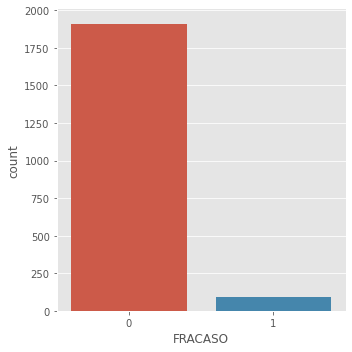

In [105]:
sns.catplot(x = "FRACASO", data = train_fill, kind = "count")

In [108]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(9, 5))
axes = axes.flat
columnas_numeric = train_fill.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('FRACASO')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = train_fill,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*4)[i]["color"],
        
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");